## Classification

In [401]:
# Import stuff
import numpy as np
import scipy
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
import skymapper as skm
from code.plot_utils import plot_pretty
from astropy import units as u
from astropy.coordinates import SkyCoord
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

%matplotlib inline
%pylab inline 
plot_pretty() 

Populating the interactive namespace from numpy and matplotlib


In [402]:
from Train_set import supervised

In [403]:
y_train, X_train = supervised()

In [404]:
# Import support vector machines
import sklearn
from sklearn.svm import SVC
svc_first = SVC(C=1e6,kernel='rbf')

In [405]:
# Fit the data now
svc_first.fit(X_train, y_train)

SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [406]:
svc_first.score(X_train,y_train)

1.0

In [407]:
REG_big = fits.open('Big_region.fits')
print REG_big[1].header.keys

<bound method Header.keys of XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  128 / length of dimension 1                          
NAXIS2  =              6175361 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   28 / number of table fields                         
TTYPE1  = 'ra      '                                                            
TFORM1  = 'D       '                                                            
TTYPE2  = 'dec     '                                                            
TFORM2  = 'D       '                                                            

In [408]:
# Import everything 
# ========================================================
# ========================================================
# spread_model_i and its error
spread_model_i = REG_big[1].data['spread_model_i']
speraderr_model_i = REG_big[1].data['spreaderr_model_i']

# RA and DEC 
RA = REG_big[1].data['ra']
DEC = REG_big[1].data['dec']

# Redshifts
dnf_zmean = REG_big[1].data['dnf_zmean_mof']
dnf_zmc = REG_big[1].data['dnf_zmc_mof']
bpz_zmean = REG_big[1].data['bpz_zmean_mof']
bpz_zmc = REG_big[1].data['bpz_zmc_mof']


# Image A/ Image B
IMAGE_A = REG_big[1].data['a_image']
IMAGE_B = REG_big[1].data['b_image']

# Magnitudes 
MAG_AUTO_G = REG_big[1].data['mag_auto_g']
MAG_AUTO_R = REG_big[1].data['mag_auto_r']
MAG_AUTO_I = REG_big[1].data['mag_auto_i']

# Flux radii - convert from pixels to arcseconds
FLUX_RADIUS_G = 0.263*REG_big[1].data['flux_radius_g']
FLUX_RADIUS_R = 0.263*REG_big[1].data['flux_radius_r']
FLUX_RADIUS_I = 0.263*REG_big[1].data['flux_radius_i'] 

# ================================================================================
# ================================================================================
# SURFACE BRIGHTNESSES

##Effective model surface brightness (SB) above background [mag/sq. arcmin]. 
#SB at the isophote which includes half of the flux from the model, above background
MU_EFF_G = REG_big[1].data['mu_eff_model_g']
MU_EFF_R = REG_big[1].data['mu_eff_model_r']
MU_EFF_I = REG_big[1].data['mu_eff_model_i']

#Peak surface brightness above background [mag/asec^2]
MU_MAX_G = REG_big[1].data['mu_max_g']
MU_MAX_R = REG_big[1].data['mu_max_r']
MU_MAX_I = REG_big[1].data['mu_max_i']

#Peak surface brightness above background  - using Model[mag/asec^2]
MU_MAX_MODEL_G = REG_big[1].data['mu_max_model_g']
MU_MAX_MODEL_R = REG_big[1].data['mu_max_model_r']
MU_MAX_MODEL_I = REG_big[1].data['mu_max_model_i']

#Mean surface brightness using the whole area inside the isophote used for MU_EFF_MODEL
MU_MEAN_G = REG_big[1].data['mu_mean_model_g']
MU_MEAN_R = REG_big[1].data['mu_mean_model_r']
MU_MEAN_I = REG_big[1].data['mu_mean_model_i']


# Define ellipticity 
ellipticity = 1.0 - IMAGE_B/IMAGE_A

print(len(RA))

6175361


In [409]:
# Define the cuts here 
# ====================================================

# Star-galaxy separation 
star_gal_cut = ((spread_model_i+(5.0/3.0)*speraderr_model_i)>0.007)

# Surface brightness cut
mu_eff_cut = (MU_EFF_G > 24.3)

# Color cuts 
col_1 = ((MAG_AUTO_G - MAG_AUTO_I)>(-0.1))
col_2 = ((MAG_AUTO_G - MAG_AUTO_I)<(1.4))
col_3 = ((MAG_AUTO_G - MAG_AUTO_R) > 0.7*(MAG_AUTO_G - MAG_AUTO_I) - 0.4)
col_4 = ((MAG_AUTO_G - MAG_AUTO_R) < 0.7*(MAG_AUTO_G - MAG_AUTO_I) + 0.4)
color_cuts = col_1&col_2&col_3&col_4

# Radius cut
radius_cut = ((FLUX_RADIUS_I > 2.5)&(FLUX_RADIUS_I < 20.0))

# Ellipticity cut
ell_cut = (ellipticity < 0.6)

# Summarize the final cut

Total_cut = star_gal_cut&mu_eff_cut&color_cuts&radius_cut&ell_cut

# RA and DEC
RA = RA[Total_cut]
DEC = DEC[Total_cut]

# Redshifts
dnf_zmean = dnf_zmean[Total_cut]
dnf_zmc = dnf_zmc[Total_cut]
bpz_zmean = bpz_zmean[Total_cut]
bpz_zmc = bpz_zmc[Total_cut]

# Image A/ Image B
IMAGE_A = IMAGE_A[Total_cut]
IMAGE_B = IMAGE_B[Total_cut]

#Magnitudes 
MAG_AUTO_G = MAG_AUTO_G[Total_cut]
MAG_AUTO_R = MAG_AUTO_R[Total_cut]
MAG_AUTO_I = MAG_AUTO_I[Total_cut]

#Flux radii 
FLUX_RADIUS_G = FLUX_RADIUS_G[Total_cut]
FLUX_RADIUS_R = FLUX_RADIUS_R[Total_cut]
FLUX_RADIUS_I = FLUX_RADIUS_I[Total_cut]

# ================================================================================
# ================================================================================
# SURFACE BRIGHTNESSES

##Effective model surface brightness (SB) above background [mag/sq. arcmin]. 
#SB at the isophote which includes half of the flux from the model, above background
MU_EFF_G = MU_EFF_G[Total_cut]
MU_EFF_R = MU_EFF_R[Total_cut]
MU_EFF_I = MU_EFF_I[Total_cut]

#Peak surface brightness above background [mag/asec^2]
MU_MAX_G = MU_MAX_G[Total_cut]
MU_MAX_R = MU_MAX_R[Total_cut]
MU_MAX_I = MU_MAX_I[Total_cut]

#Peak surface brightness above background  - using Model[mag/asec^2]
MU_MAX_MODEL_G = MU_MAX_MODEL_G[Total_cut]
MU_MAX_MODEL_R = MU_MAX_MODEL_R[Total_cut]
MU_MAX_MODEL_I = MU_MAX_MODEL_I[Total_cut]

#Mean surface brightness using the whole area inside the isophote used for MU_EFF_MODEL
MU_MEAN_G = MU_MEAN_G[Total_cut]
MU_MEAN_R = MU_MEAN_R[Total_cut]
MU_MEAN_I = MU_MEAN_I[Total_cut]

# Ellipticity
ellipticity = ellipticity[Total_cut]

print(len(RA))

3597


In [410]:
# Define the colors
col_g_r = MAG_AUTO_G - MAG_AUTO_R
col_g_i = MAG_AUTO_G - MAG_AUTO_I
col_i_r = MAG_AUTO_G - MAG_AUTO_R



# Define the train data matrix of features
X_feat_test = np.zeros([len(RA),16])
X_feat_test[:,0] = MAG_AUTO_G;X_feat_test[:,1] = MAG_AUTO_R;X_feat_test[:,2] = MAG_AUTO_I
X_feat_test[:,3] = col_g_r;X_feat_test[:,4] = col_g_i;X_feat_test[:,5] = col_i_r
X_feat_test[:,6] = FLUX_RADIUS_G;X_feat_test[:,7] = FLUX_RADIUS_R;X_feat_test[:,8] = FLUX_RADIUS_I
X_feat_test[:,9] = MU_EFF_G;X_feat_test[:,10] = MU_EFF_R;X_feat_test[:,11] = MU_EFF_I
X_feat_test[:,12] = MU_MAX_G; X_feat_test[:,13] =  MU_MAX_R;X_feat_test[:,14] =  MU_MAX_I
X_feat_test[:,15] = ellipticity 

In [411]:
# Let's predict now
y_pred = svc_first.predict(X_feat_test)

In [412]:
radius_g_pos = FLUX_RADIUS_G[(y_pred==1)]
RA_pos = RA[(y_pred==1)]
DEC_pos = DEC[(y_pred==1)]
z_dnf_pos = dnf_zmean[(y_pred==1)]
ell_pos = ellipticity[(y_pred==1)]
print(len(RA_pos))

812


In [413]:
for i in range(100):
    print RA_pos[i],',',DEC_pos[i]

49.931776 , -26.333853
52.425021 , -32.678759
51.646594 , -34.499116
48.807117 , -33.398849
54.086329 , -29.86515
51.166767 , -33.21693
46.230174 , -31.06137
53.322958 , -26.114286
54.174329 , -34.71152
53.787343 , -31.059562
54.433597 , -32.431069
53.839934 , -33.944497
46.33235 , -30.028021
49.909634 , -26.408788
54.972575 , -27.721498
50.904153 , -28.393043
52.919467 , -32.841758
45.899512 , -26.405208
52.089586 , -33.825619
51.561213 , -25.985841
52.930947 , -28.753485
54.891178 , -25.609931
53.706881 , -28.143295
52.901214 , -32.846805
47.930051 , -26.977681
54.234678 , -25.864424
49.62028 , -25.492342
46.365126 , -27.753551
50.54091 , -28.251239
45.268216 , -25.350444
52.609628 , -26.238668
54.547306 , -33.451631
54.670864 , -27.50381
45.147381 , -25.263726
49.236144 , -30.404226
45.581325 , -25.552204
49.088603 , -25.620282
50.4859 , -29.164723
48.321806 , -25.98053
51.694002 , -34.808057
53.940358 , -30.072847
49.284952 , -32.568635
52.550191 , -26.640661
53.284111 , -30.265042

In [414]:
for i in range(100,200):
    print RA_pos[i],',',DEC_pos[i]

51.766631 , -34.109091
45.849949 , -29.080192
54.306422 , -26.480741
53.491969 , -28.479141
52.359484 , -26.079798
49.454423 , -30.959356
51.241669 , -33.230476
46.729441 , -26.510629
52.44778 , -26.870487
51.710554 , -32.678441
52.984471 , -32.216278
52.997589 , -28.328223
54.104047 , -25.716723
50.991026 , -26.289837
54.796883 , -31.62187
46.924205 , -34.187232
51.035971 , -33.825956
48.119571 , -33.561758
53.503605 , -27.838927
49.23795 , -30.405217
48.084278 , -32.836755
50.231698 , -26.67636
49.520323 , -25.82671
53.982302 , -34.828106
51.889764 , -26.880548
49.594851 , -28.538172
49.583188 , -27.088963
53.891581 , -34.804701
50.343169 , -29.535693
45.208773 , -32.53334
52.18862 , -25.329288
48.472394 , -34.817468
54.242841 , -26.20935
51.23174 , -28.099512
51.604441 , -26.461812
54.423955 , -26.757234
51.95912 , -30.787147
50.309479 , -26.099116
53.152317 , -34.105827
46.144722 , -27.218245
54.284031 , -34.73123
52.312031 , -34.921756
48.781857 , -25.920196
47.162894 , -27.319753

In [415]:
radius_g_big = radius_g_pos[(radius_g_pos>4.5)]
z_dnf_big = z_dnf_pos[(radius_g_pos>4.5)]
RA_big = RA_pos[(radius_g_pos>4.5)]
DEC_big = DEC_pos[(radius_g_pos>4.5)]
print(len(RA_big))

143


In [416]:
for i in range(len(RA_big)):
    print RA_big[i],',',DEC_big[i]

51.646594 , -34.499116
48.807117 , -33.398849
46.230174 , -31.06137
54.433597 , -32.431069
45.899512 , -26.405208
52.901214 , -32.846805
47.930051 , -26.977681
49.236144 , -30.404226
49.284952 , -32.568635
54.044822 , -25.359792
53.642431 , -26.05558
53.269644 , -25.075834
53.31904 , -26.056307
48.931605 , -33.543557
52.445824 , -26.872019
54.202762 , -34.280153
52.751095 , -25.666917
52.073198 , -26.07793
51.256401 , -27.063155
49.284237 , -32.568629
54.630797 , -31.540584
46.368686 , -32.558936
52.44778 , -26.870487
49.520323 , -25.82671
53.982302 , -34.828106
53.891581 , -34.804701
51.95912 , -30.787147
48.520147 , -31.800171
50.84008 , -29.578395
48.075896 , -26.219702
47.872364 , -31.381995
51.337705 , -33.325137
53.557672 , -29.809935
51.860625 , -26.323792
50.70701 , -31.438706
53.126456 , -34.348466
51.528923 , -31.188426
49.530328 , -34.168635
53.31932 , -31.448739
53.217972 , -28.094099
53.988079 , -31.07533
54.787278 , -33.038357
53.264956 , -33.724716
54.362842 , -26.572796

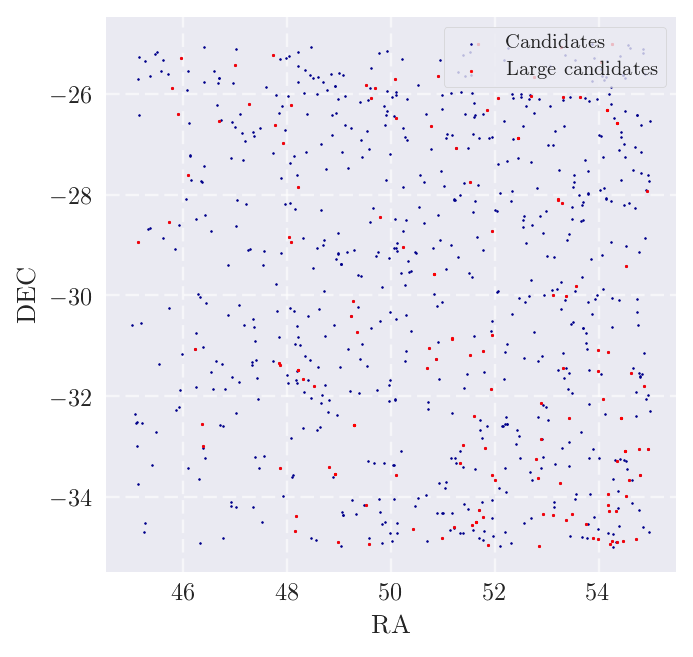

In [417]:
plot_pretty()
fig = plt.figure(figsize=(4.2,4.2))
plt.scatter(RA_pos, DEC_pos, c='darkblue', s=0.5,  label='Candidates')
plt.scatter(RA_big, DEC_big, c='red', s=1.0,  label='Large candidates')
plt.xlabel('RA'); plt.ylabel('DEC')
plt.grid(ls='--', alpha=0.6)
#plt.xlim(53.5,56.0)
plt.legend(frameon=True, loc='upper right', fontsize=8)
plt.show()

## Data processing and exploration

Let's process these data and make some Greco-like plots

In [418]:
# Properties 
radius_g_pos = FLUX_RADIUS_G[(y_pred==1)&(dnf_zmean>0)]
RA_pos = RA[(y_pred==1)&(dnf_zmean>0)]
DEC_pos = DEC[(y_pred==1)&(dnf_zmean>0)]
z_dnf_pos = dnf_zmean[(y_pred==1)&(dnf_zmean>0)]
col_g_r_pos = col_g_r[(y_pred==1)&(dnf_zmean>0)]
col_g_i_pos = col_g_i[(y_pred==1)&(dnf_zmean>0)]
col_i_r_pos = col_i_r[(y_pred==1)&(dnf_zmean>0)]
ell_pos = ellipticity[(y_pred==1)&(dnf_zmean>0)]
mu_eff_g_pos = MU_EFF_G[(y_pred==1)&(dnf_zmean>0)]

Plot the redshift distribution of the objects

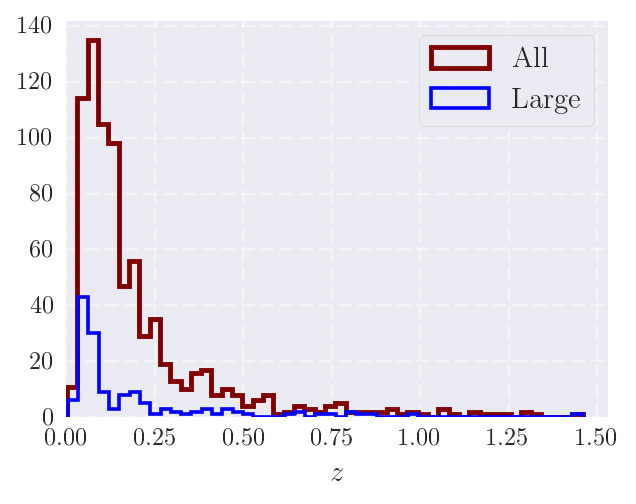

In [419]:
plot_pretty()
fig = plt.figure(figsize=(4.0,3.0))
plt.hist(z_dnf_pos, bins=50, histtype='step', color='maroon', linewidth=2.0, label='All')
plt.hist(z_dnf_pos[(radius_g_pos>4.5)], bins=50, histtype='step', color='blue', linewidth=1.5, label='Large')
plt.grid(ls='--', alpha=0.5)
plt.legend(frameon=True, loc='upper right', fontsize=12)
plt.xlim(0.0,)
plt.xlabel('$z$', fontsize=12)
plt.show()

Let's keep only those with $z <0.4$ (random choice) and make some plots

In [420]:
radius_g_2 = radius_g_pos[(z_dnf_pos<0.4)]
RA_2 = RA_pos[(z_dnf_pos<0.4)]
DEC_2 = DEC_pos[(z_dnf_pos<0.4)]
z_dnf_2 = z_dnf_pos[(z_dnf_pos<0.4)]
col_g_r_2 = col_g_r_pos[(z_dnf_pos<0.4)]
col_g_i_2 = col_g_i_pos[(z_dnf_pos<0.4)]
col_i_r_2 = col_i_r_pos[(z_dnf_pos<0.4)]
ell_2 = ell_pos[(z_dnf_pos<0.4)]
mu_eff_g_2 = mu_eff_g_pos[(z_dnf_pos<0.4)]

print(len(RA_2))

700


#### Color-color diagram

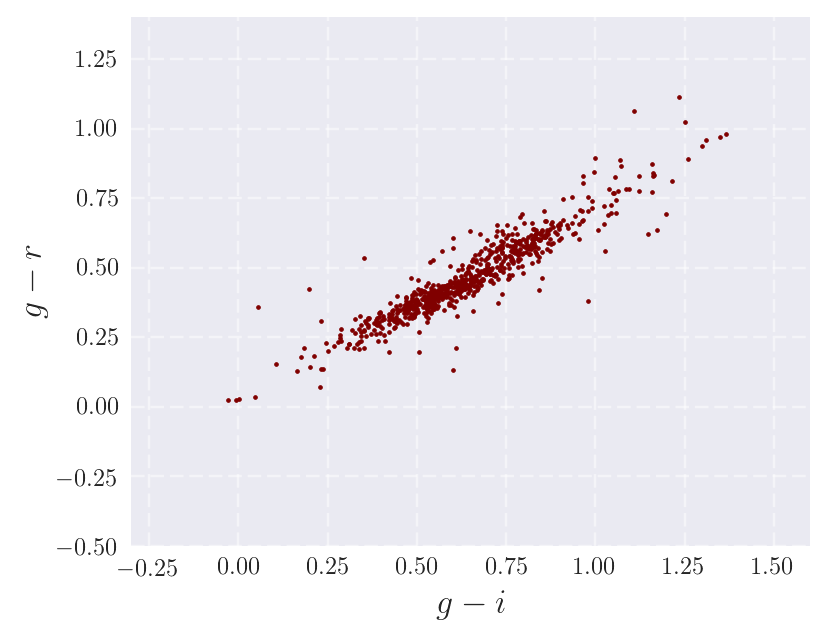

In [422]:
plot_pretty()
fig = plt.figure(figsize=(5.0,4.0))
plt.scatter(col_g_i_2,col_g_r_2, s=2.5, color='maroon')
plt.grid(ls='--', alpha=0.5)
plt.ylim(-0.50,1.4)
plt.xlim(-0.30,1.60)
plt.xlabel('$g-i$', fontsize=14)
plt.ylabel('$g-r$', fontsize=14)
plt.show()


Let's repeat this plot using seaborn, in order to get the marginal distributions on the sides

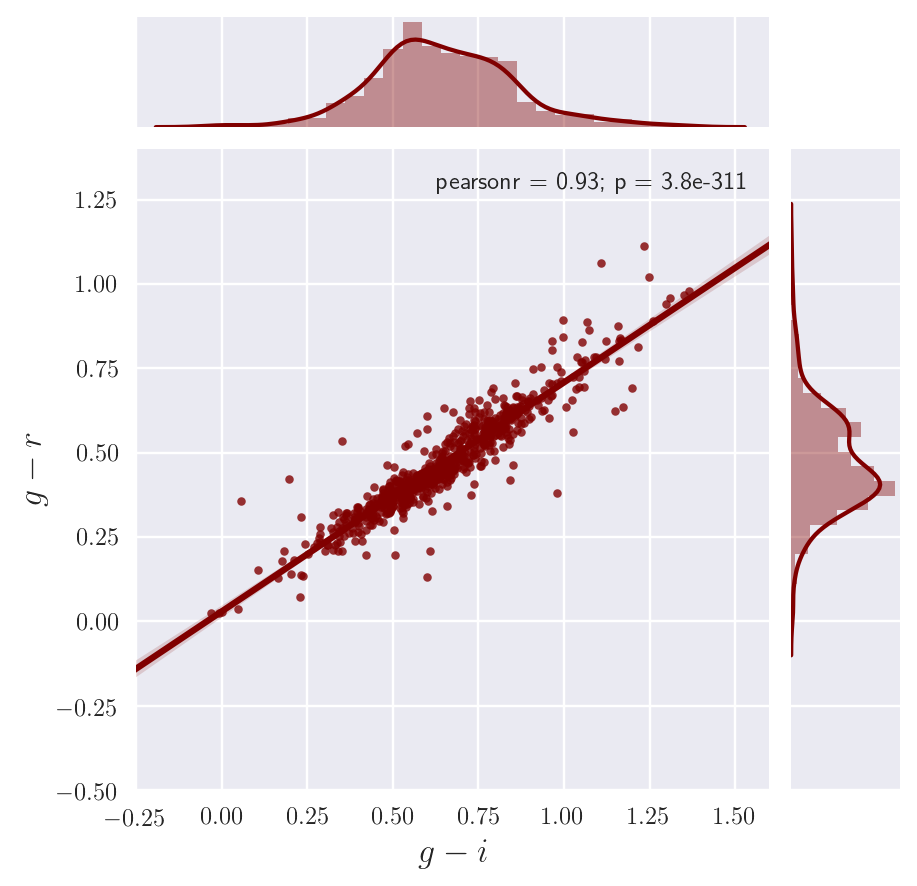

In [423]:
import seaborn as sns
sns.set()
#plt.figure(figsize=(2.0,1.0))
g = sns.jointplot(col_g_i_2, col_g_r_2,kind='reg', color='maroon',marker='.', size=5.0)
plt.ylim(-0.50,1.4)
plt.xlim(-0.25,1.60)
plt.xlabel('$g-i$', fontsize=14)
plt.ylabel('$g-r$', fontsize=14)
plt.show()

Let's compare with the total sample, before the fit

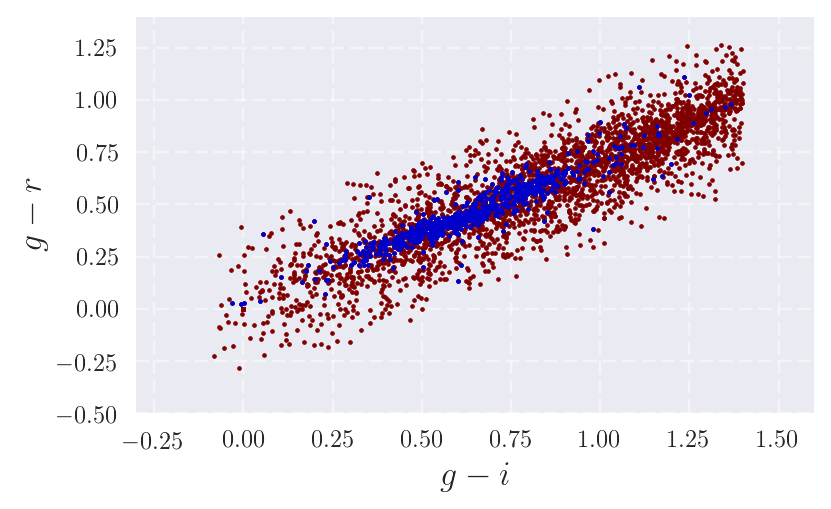

In [424]:
plot_pretty()
sns.set()
fig = plt.figure(figsize=(5.0,3.0))
plt.scatter(col_g_i,col_g_r, s=2.5, color='maroon')
plt.scatter(col_g_i_2,col_g_r_2, s=2.5, color='mediumblue')
plt.grid(ls='--', alpha=0.5)
plt.ylim(-0.50,1.4)
plt.xlim(-0.30,1.60)
plt.xlabel('$g-i$', fontsize=14)
plt.ylabel('$g-r$', fontsize=14)
plt.show()



Now, define red galaxies as those with $g-i \geq 0.64$ and blue galaxies those with $g-i < 0.64$ and make some more plots

In [425]:
r_eff_red = radius_g_2[(col_g_i_2>=0.64)]
r_eff_blue = radius_g_2[(col_g_i_2<0.64)]
mu_eff_red = mu_eff_g_2[(col_g_i_2>=0.64)] 
mu_eff_blue = mu_eff_g_2[(col_g_i_2<0.64)] 

print(len(r_eff_red))
print(len(r_eff_blue))

339
361


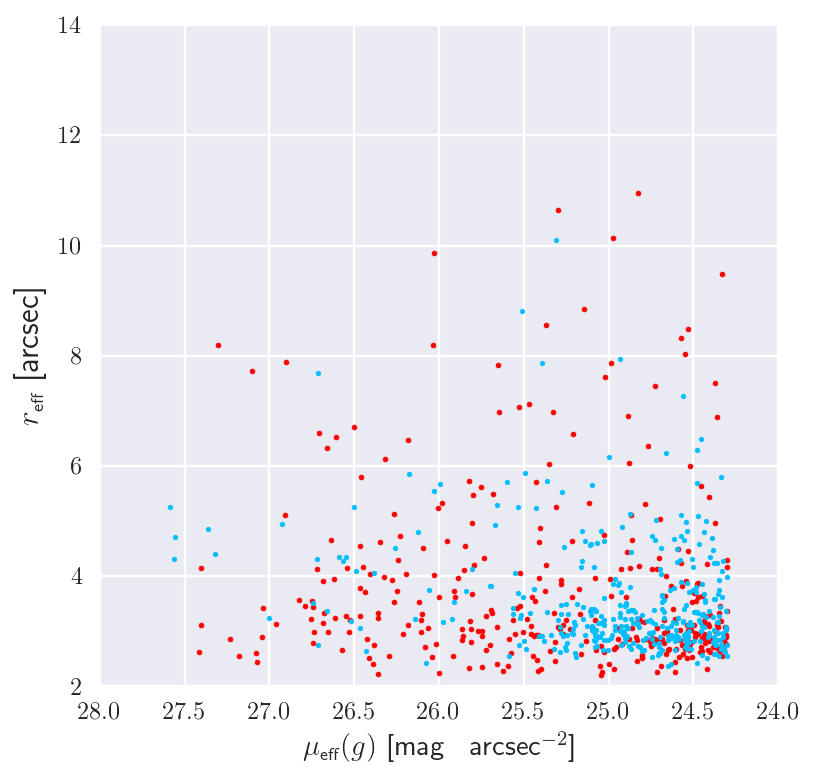

In [426]:
sns.set()
plt.figure(figsize=(5.0,5.0))
plt.scatter(mu_eff_red,r_eff_red, s=4.0, color='red')
plt.scatter(mu_eff_blue,r_eff_blue, s=3.5, color='deepskyblue')

plt.ylim(2.0,14.0)
plt.xlim(28.0,24.0)
plt.xlabel('$\mu_{\mbox{\scriptsize{eff}}}(g)$ [mag \, arcsec$^{-2}$]', fontsize=12)
plt.ylabel('$r_{\mbox{\scriptsize{eff}}}$ [arcsec]', fontsize=13)
plt.show()

Compare with the general population

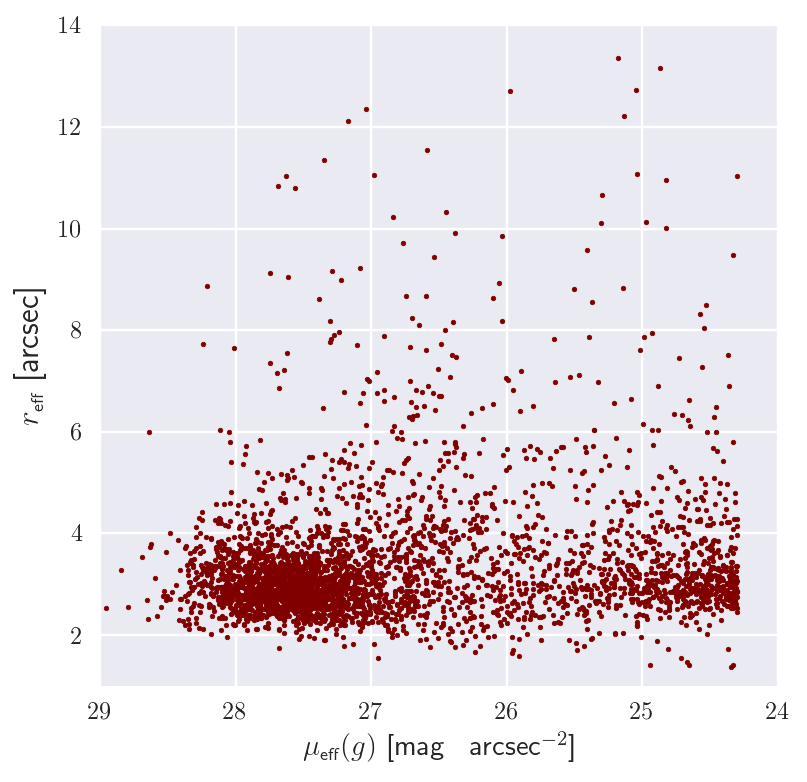

In [427]:
sns.set()
plt.figure(figsize=(5.0,5.0))
plt.scatter(MU_EFF_G,FLUX_RADIUS_G, s=3.5, color='maroon')

plt.ylim(1.0,14.0)
plt.xlim(29.0,24.0)
plt.xlabel('$\mu_{\mbox{\scriptsize{eff}}}(g)$ [mag \, arcsec$^{-2}$]', fontsize=12)
plt.ylabel('$r_{\mbox{\scriptsize{eff}}}$ [arcsec]', fontsize=13)
plt.show()

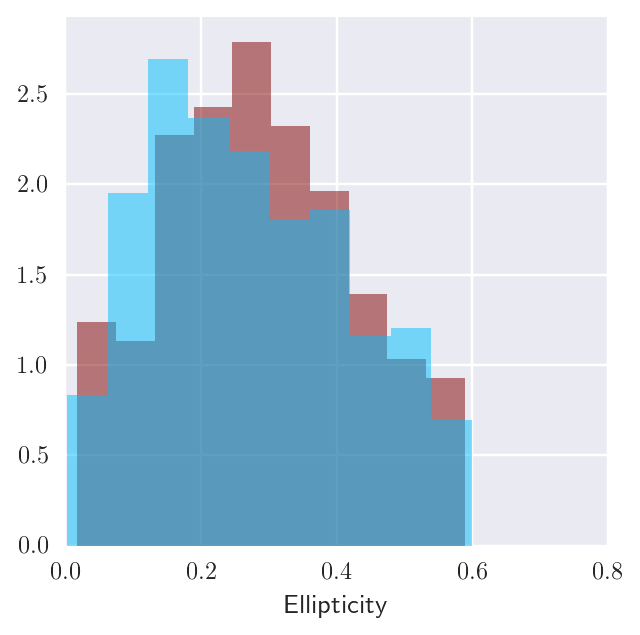

In [442]:
ell_red = ell_2[(col_g_i_2>=0.64)]
ell_blue = ell_2[(col_g_i_2<0.64)]

plt.figure(figsize=(4.0,4.0))
plt.hist(ell_red, bins=10,normed=True, color='maroon', alpha=0.5)
plt.hist(ell_blue, bins=10,normed=True, color='deepskyblue', alpha=0.5)

plt.xlim(0.0,0.8)
plt.xlabel('Ellipticity')
plt.show()

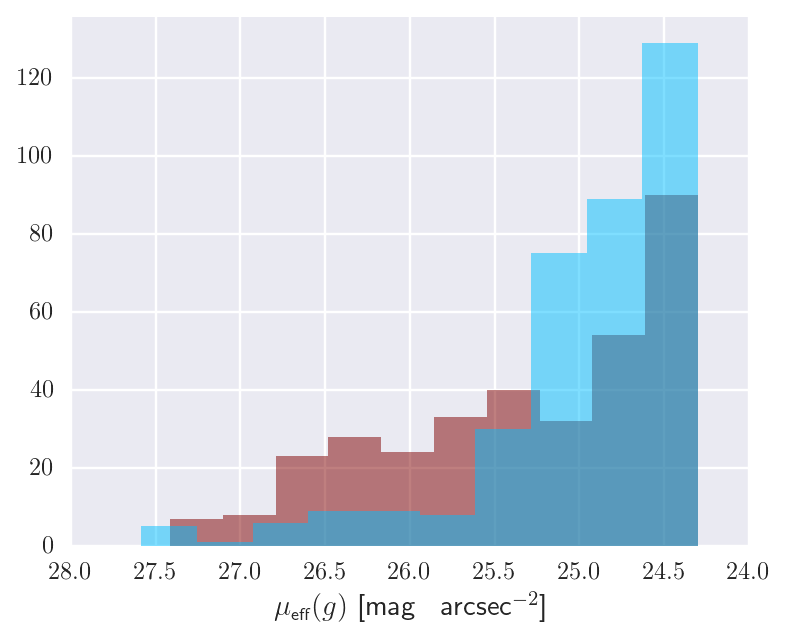

In [451]:
plt.figure(figsize=(5.0,4.0))
plt.hist(mu_eff_red, color='maroon', alpha=0.5)
plt.hist(mu_eff_blue, color='deepskyblue', alpha=0.5)
plt.xlim(28,24.0)
plt.xlabel('$\mu_{\mbox{\scriptsize{eff}}}(g)$ [mag \, arcsec$^{-2}$]', fontsize=12)
plt.show()